In [2]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [39]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     29.251700     28.981150   
                          BTC     10532.400561  10596.176732  10451.465293   
                          ETH       221.191514    224.079639    221.015166   
                          XRP         0.319763      0.323658      0.319140   
2019-07-20 01:00:00+00:00 BNB        29.102050     30.051750     28.937300   
...                                        ...           ...           ...   
2022-09-02 08:00:00+00:00 ETH      1594.401429   1596.874286   1585.030000   
                          LINK        6.882598      6.912045      6.853060   
                          MATIC       0.881401      0.890773      0.880405   
                          SOL        31.624165     31.658390     31.415591   
                          XRP         0.331690      0.331690      0.330483   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        29.102300 2019-07-20 01:00:00+00:00   
                          BTC     10466.256172 2019-07-20 01:00:00+00:00   
                          ETH       221.450416 2019-07-20 01:00:00+00:00   
                          XRP         0.319678 2019-07-20 01:00:00+00:00   
2019-07-20 01:00:00+00:00 BNB        30.036500 2019-07-20 02:00:00+00:00   
...                                        ...                       ...   
2022-09-02 08:00:00+00:00 ETH      1590.434286 2022-09-02 09:00:00+00:00   
                          LINK        6.873536 2022-09-02 09:00:00+00:00   
                          MATIC       0.890107 2022-09-02 09:00:00+00:00   
                          SOL        31.562069 2022-09-02 09:00:00+00:00   
                          XRP         0.330670 2022-09-02 09:00:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB     0.063542  
                          BTC     0.034167  
                          ETH     0.034369  
                          XRP     0.043545  
2019-07-20 01:00:00+00:00 BNB     0.016383  
...                                    ...  
2022-09-02 08:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[245753 rows x 6 columns]

,symbol,op,hi,lo,cl,execution_start_at,ret,close_time,cl_cme,cl_cme_weekly,cl_cme_open,cl_cme_weekly_open,ret_cl
timestamp,,,,,,,,,,,,,
2019-07-26 20:00:00+00:00,BTC,9849.960178,9858.975695,9762.003021,9827.790119,2019-07-26 21:00:00+00:00,-0.034193,2019-07-26 21:00:00+00:00,9827.790119,9827.790119,9888.763098,10567.123683,-0.003258
2019-07-26 21:00:00+00:00,BTC,9827.501609,9839.661850,9776.227167,9818.627000,2019-07-26 22:00:00+00:00,-0.032894,2019-07-26 22:00:00+00:00,9827.790119,9827.790119,9888.763098,10567.123683,0.004839
2019-07-26 22:00:00+00:00,BTC,9818.627000,9825.971288,9779.948267,9786.637002,2019-07-26 23:00:00+00:00,-0.037416,2019-07-26 23:00:00+00:00,9827.790119,9827.790119,9888.763098,10567.123683,0.032185
2019-07-26 23:00:00+00:00,BTC,9786.637002,9845.339186,9783.785118,9833.994107,2019-07-27 00:00:00+00:00,-0.066183,2019-07-27 00:00:00+00:00,9827.790119,9827.790119,9888.763098,10567.123683,-0.002468
2019-07-27 00:00:00+00:00,BTC,9833.994107,10182.802581,9813.802388,10150.504619,2019-07-27 01:00:00+00:00,-0.067658,2019-07-27 01:00:00+00:00,9827.790119,9827.790119,9888.763098,10567.123683,0.000428
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-05 10:00:00+00:00,BTC,19769.770000,19785.018571,19659.845714,19694.890000,2022-09-05 11:00:00+00:00,0.011062,2022-09-05 11:00:00+00:00,19969.492857,19969.492857,19865.377143,19865.377143,0.001586
2022-09-05 11:00:00+00:00,BTC,19691.452857,19717.090000,19642.298571,19698.002857,2022-09-05 12:00:00+00:00,0.010443,2022-09-05 12:00:00+00:00,19969.492857,19969.492857,19865.377143,19865.377143,0.000576
2022-09-05 12:00:00+00:00,BTC,19699.631429,19749.250000,19669.931429,19729.252857,2022-09-05 13:00:00+00:00,0.004012,2022-09-05 13:00:00+00:00,19969.492857,19969.492857,19865.377143,19865.377143,0.005257


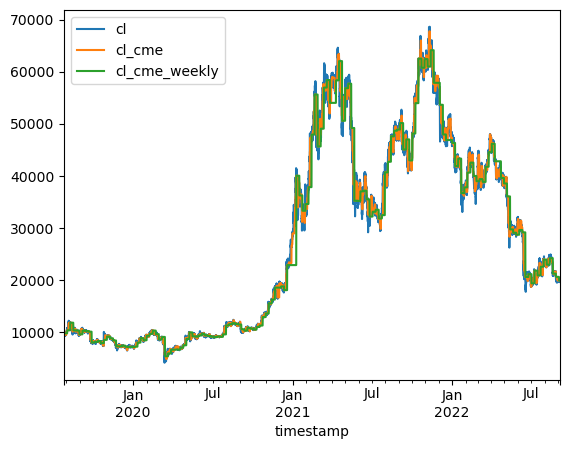

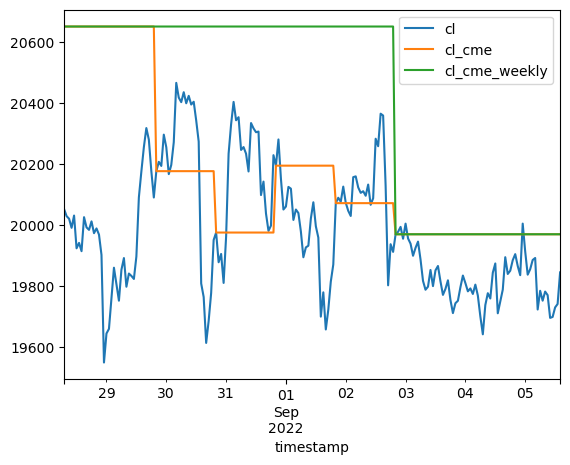

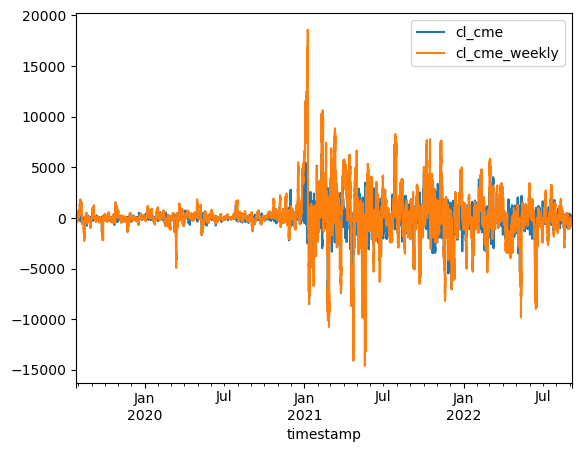

PearsonRResult(statistic=-0.009520915125999481, pvalue=0.5528545635029909)
PearsonRResult(statistic=-0.00861368889646353, pvalue=0.5913133826938123)
PearsonRResult(statistic=-0.004371503550522219, pvalue=0.7852424815822542)
PearsonRResult(statistic=-0.019741023019366453, pvalue=0.2184528660986206)


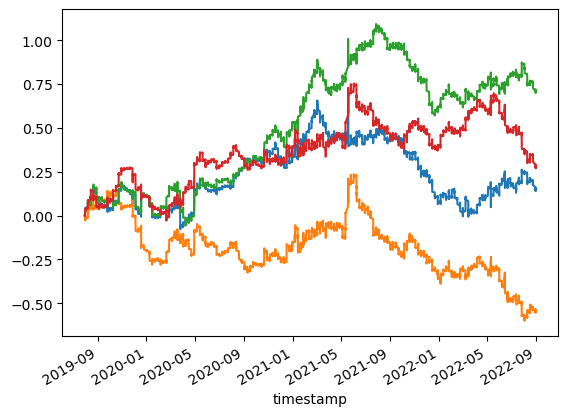

In [73]:
import talib
from scipy.stats import spearmanr, pearsonr
import pandas_market_calendars as mcal
from scipy.stats import pearsonr

cme = mcal.get_calendar('CMEGlobex_FX')
# cme = mcal.get_calendar('NYSE')
df_cme = cme.schedule(start_date='2015-01-01', end_date='2030-01-01')

df = pd.read_pickle('/tmp/df.pkl')
df = df.loc[df.index.get_level_values('symbol') == 'BTC']
df = df.reset_index().set_index('timestamp')
df['close_time'] = df.index.get_level_values('timestamp') + pd.to_timedelta(1, 'H')

# idx_cme = df['close_time'].dt.hour == 13
idx_cme = df['close_time'].isin(df_cme['market_close'])
df.loc[idx_cme, 'cl_cme'] = df.loc[idx_cme, 'cl']
df.loc[idx_cme & (df['close_time'].dt.dayofweek == 4), 'cl_cme_weekly'] = df.loc[idx_cme & (df['close_time'].dt.dayofweek == 4), 'cl']

# idx_cme = df['close_time'].dt.hour == 7
idx_cme = df['close_time'].isin(df_cme['market_open'])
df.loc[idx_cme, 'cl_cme_open'] = df.loc[idx_cme, 'cl']
df.loc[idx_cme & (df['close_time'].dt.dayofweek == 6), 'cl_cme_weekly_open'] = df.loc[idx_cme & (df['close_time'].dt.dayofweek == 6), 'cl']

df[['cl_cme', 'cl_cme_weekly', 'cl_cme_open', 'cl_cme_weekly_open']] = df[['cl_cme', 'cl_cme_weekly', 'cl_cme_open', 'cl_cme_weekly_open']].ffill()

df['ret_cl'] = df['cl'].shift(-2) / df['cl'].shift(-1) - 1
df = df.dropna()

display(df)

df[['cl', 'cl_cme', 'cl_cme_weekly']].plot()
plt.show()

df[['cl', 'cl_cme', 'cl_cme_weekly']].iloc[-200:].plot()
plt.show()

(df['cl'].values.reshape(-1, 1) - df[['cl_cme', 'cl_cme_weekly']]).plot()
plt.show()

# df = df.loc[df['close_time'].dt.dayofweek == 5]
df = df.loc[df['close_time'].dt.dayofweek == 2]
# df = df.loc[df['close_time'].dt.dayofweek == 1]

print(pearsonr(np.log(df['cl'] / df['cl_cme']), df['ret_cl']))
print(pearsonr(np.log(df['cl'] / df['cl_cme_weekly']), df['ret_cl']))
print(pearsonr(np.log(df['cl'] / df['cl_cme_open']), df['ret_cl']))
print(pearsonr(np.log(df['cl'] / df['cl_cme_weekly_open']), df['ret_cl']))

(df['ret_cl'] * np.sign(np.log(df['cl'] / df['cl_cme']))).cumsum().plot()
(df['ret_cl'] * np.sign(np.log(df['cl'] / df['cl_cme_weekly']))).cumsum().plot()
(df['ret_cl'] * np.sign(np.log(df['cl'] / df['cl_cme_open']))).cumsum().plot()
(df['ret_cl'] * np.sign(np.log(df['cl'] / df['cl_cme_weekly_open']))).cumsum().plot()
plt.show()


,symbol,op,hi,lo,cl,execution_start_at,ret,ret_cl,cl_diff
timestamp,,,,,,,,,
2019-07-21 00:00:00+00:00,BTC,10758.259167,10828.854075,10703.893335,10801.139629,2019-07-21 01:00:00+00:00,-0.020415,-0.012471,0.031996
2019-07-21 01:00:00+00:00,BTC,10801.139629,10825.367586,10787.038173,10810.456153,2019-07-21 02:00:00+00:00,-0.008955,-0.007880,0.035896
2019-07-21 02:00:00+00:00,BTC,10810.456153,10812.834953,10645.488325,10675.641594,2019-07-21 03:00:00+00:00,0.000664,0.005388,0.015648
2019-07-21 03:00:00+00:00,BTC,10675.641594,10675.641594,10577.700179,10591.513400,2019-07-21 04:00:00+00:00,-0.007623,-0.005902,0.005680
2019-07-21 04:00:00+00:00,BTC,10591.513400,10676.786677,10567.297866,10648.578230,2019-07-21 05:00:00+00:00,-0.004888,0.002002,0.002853
...,...,...,...,...,...,...,...,...,...
2022-09-05 10:00:00+00:00,BTC,19769.770000,19785.018571,19659.845714,19694.890000,2022-09-05 11:00:00+00:00,0.011062,0.001586,-0.003227
2022-09-05 11:00:00+00:00,BTC,19691.452857,19717.090000,19642.298571,19698.002857,2022-09-05 12:00:00+00:00,0.010443,0.000576,-0.007325
2022-09-05 12:00:00+00:00,BTC,19699.631429,19749.250000,19669.931429,19729.252857,2022-09-05 13:00:00+00:00,0.004012,0.005257,-0.007264


PearsonRResult(statistic=0.01617792395182731, pvalue=0.3107995314491399)
PearsonRResult(statistic=-0.04629900227985658, pvalue=0.0037741753201714244)
PearsonRResult(statistic=-0.003137899959673585, pvalue=0.8444530021525541)
PearsonRResult(statistic=0.08232276395298065, pvalue=2.5219211135870725e-07)
PearsonRResult(statistic=-0.08095830035183503, pvalue=3.9714232000026503e-07)
PearsonRResult(statistic=-0.05098630833032, pvalue=0.0014225089627049998)
PearsonRResult(statistic=-0.03699930834536877, pvalue=0.02027047579530706)


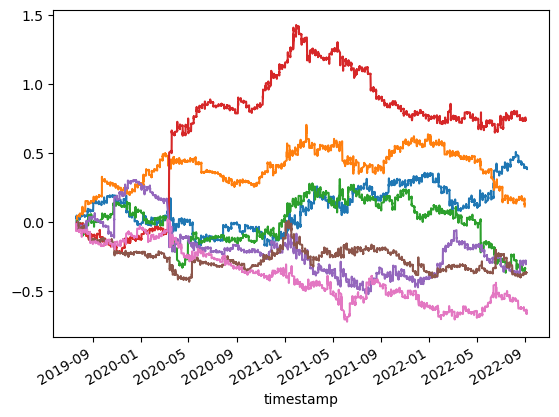

In [81]:
import talib
from scipy.stats import spearmanr, pearsonr
import pandas_market_calendars as mcal
from scipy.stats import pearsonr

df = pd.read_pickle('/tmp/df.pkl')
df = df.loc[df.index.get_level_values('symbol') == 'BTC']
df = df.reset_index().set_index('timestamp')
df['ret_cl'] = df['cl'].shift(-2) / df['cl'].shift(-1) - 1
df['cl_diff'] = df['cl'] / df['cl'].shift(24) - 1
df = df.dropna()

display(df)

for dow in range(7):
    df2 = df.loc[df.index.dayofweek == dow]
    print(pearsonr(df2['cl_diff'], df2['ret_cl']))
    (df2['ret_cl'] * np.sign(df2['cl_diff'])).cumsum().plot()
    
plt.show()
